In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [42]:
path = "/kaggle/input/plantvillage-dataset/color"

In [43]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [44]:
import os
import shutil
import random
from pathlib import Path

# Reproducibility (optional)
random.seed(42)

# Paths
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Collect classes and counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)

# Build balanced dataset:
kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

    # Skip classes with fewer than 350 images
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    # List image files and sample to exactly 350
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # If count == 350 this returns all, otherwise a downsample to 350
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [45]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [46]:
class_names = dataset.classes
num_classes = len(class_names)

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.resnet50(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [48]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [49]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
import torch.nn as nn
import torch.optim as optim

num_epochs = 50
model = models.googlenet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []
scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_36/1908827956.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_36/1908827956.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/79 [00:00<?, ?it/s]         /tmp/ipykernel_36/1908827956.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.6888, Validation Loss: 0.7833
Epoch 2/50


Train Loss: 0.6614, Validation Loss: 0.5008
Epoch 3/50


Train Loss: 0.4687, Validation Loss: 0.4075
Epoch 4/50


Train Loss: 0.3926, Validation Loss: 0.3524
Epoch 5/50


Train Loss: 0.3439, Validation Loss: 0.3142
Epoch 6/50


Train Loss: 0.3002, Validation Loss: 0.2900
Epoch 7/50


Train Loss: 0.2675, Validation Loss: 0.3058
Epoch 8/50


Train Loss: 0.2620, Validation Loss: 0.2691
Epoch 9/50


Train Loss: 0.2369, Validation Loss: 0.2681
Epoch 10/50


Train Loss: 0.2242, Validation Loss: 0.2543
Epoch 11/50


Train Loss: 0.2126, Validation Loss: 0.2496
Epoch 12/50


Train Loss: 0.2054, Validation Loss: 0.2411
Epoch 13/50


Train Loss: 0.1908, Validation Loss: 0.2419
Epoch 14/50


Train Loss: 0.1836, Validation Loss: 0.2270
Epoch 15/50


Train Loss: 0.1759, Validation Loss: 0.2254
Epoch 16/50


Train Loss: 0.1720, Validation Loss: 0.2277
Epoch 17/50


Train Loss: 0.1700, Validation Loss: 0.2234
Epoch 18/50


Train Loss: 0.1676, Validation Loss: 0.2234
Epoch 19/50


Train Loss: 0.1536, Validation Loss: 0.2211
Epoch 20/50


Train Loss: 0.1545, Validation Loss: 0.2160
Epoch 21/50


Train Loss: 0.1595, Validation Loss: 0.2230
Epoch 22/50


Train Loss: 0.1544, Validation Loss: 0.2128
Epoch 23/50


Train Loss: 0.1452, Validation Loss: 0.2112
Epoch 24/50


Train Loss: 0.1395, Validation Loss: 0.2155
Epoch 25/50


Train Loss: 0.1356, Validation Loss: 0.2236
Epoch 26/50


Train Loss: 0.1386, Validation Loss: 0.2120
Epoch 27/50


Train Loss: 0.1359, Validation Loss: 0.2043
Epoch 28/50


Train Loss: 0.1350, Validation Loss: 0.2124
Epoch 29/50


Train Loss: 0.1294, Validation Loss: 0.1997
Epoch 30/50


Train Loss: 0.1329, Validation Loss: 0.1988
Epoch 31/50


Train Loss: 0.1340, Validation Loss: 0.2082
Epoch 32/50


Train Loss: 0.1212, Validation Loss: 0.2110
Epoch 33/50


Train Loss: 0.1256, Validation Loss: 0.2082
Epoch 34/50


Train Loss: 0.1238, Validation Loss: 0.2010
Epoch 35/50


Train Loss: 0.1236, Validation Loss: 0.2066
Early stopping triggered.


In [57]:
# Define a path for saving the model
model_save_path = "googlenet_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to googlenet_model.pth


In [58]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2132857589.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8378    0.9688    0.8986        64
           1     0.9437    0.9853    0.9640        68
           2     0.9683    0.8592    0.9104        71
           3     0.9647    0.9880    0.9762        83
           4     1.0000    0.9872    0.9935        78
           5     0.9859    0.9859    0.9859        71
           6     0.9079    0.9200    0.9139        75
           7     0.9836    1.0000    0.9917        60
           8     0.8750    0.8936    0.8842        47
           9     0.9726    0.9726    0.9726        73
          10     0.9625    0.9747    0.9686        79
          11     0.9861    0.9595    0.9726        74
          12     1.0000    1.0000    1.0000        79
          13     1.0000    0.9677    0.9836        62
          14     0.9565    1.0000    0.9778        66
          15     0.9444    0.8947    0.9189        76
          16     0.9600    0.9863    0.9730        73
   

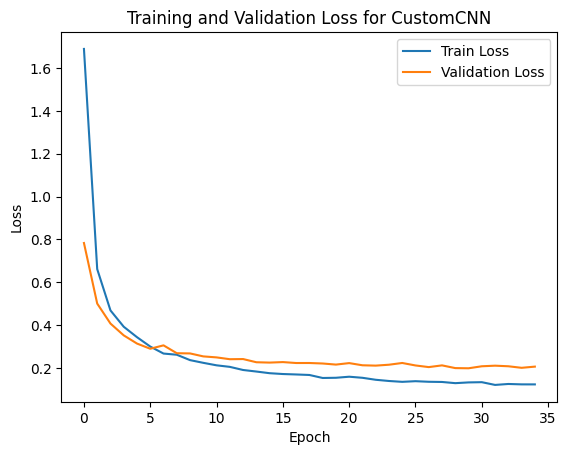

In [59]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_36/2221908313.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Testing time: 3.69 sec  |  Throughput: 341.83 samples/sec
Confusion Matrix:
 [[34  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 2  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 35  1]
 [ 0  0  0 ...  0  1 33]]

Confusion Matrix (row-normalized):
[[0.971 0.    0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.062 0.    0.938 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.946 0.    0.   ]
 [0.    0.    0.    ... 0.    0.946 0.027]
 [0.    0.    0.    ... 0.    0.029 0.943]]


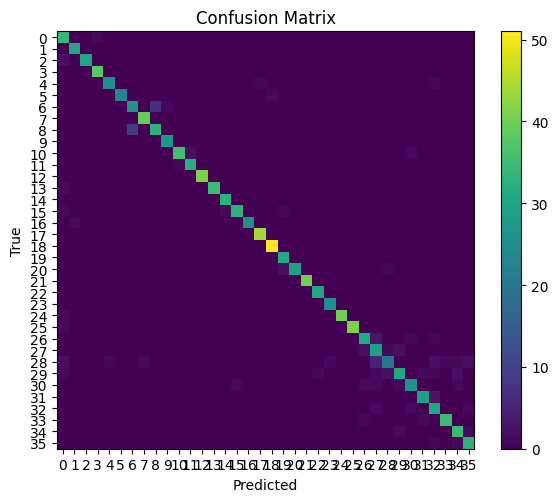

Per-class ROC AUC:
  Class 0: 0.9992
  Class 1: 1.0000
  Class 2: 0.9999
  Class 3: 1.0000
  Class 4: 0.9987
  Class 5: 1.0000
  Class 6: 0.9961
  Class 7: 1.0000
  Class 8: 0.9970
  Class 9: 1.0000
  Class 10: 0.9998
  Class 11: 0.9999
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 1.0000
  Class 15: 0.9999
  Class 16: 0.9999
  Class 17: 1.0000
  Class 18: 1.0000
  Class 19: 0.9996
  Class 20: 0.9993
  Class 21: 1.0000
  Class 22: 1.0000
  Class 23: 1.0000
  Class 24: 0.9998
  Class 25: 1.0000
  Class 26: 0.9976
  Class 27: 0.9958
  Class 28: 0.9922
  Class 29: 0.9973
  Class 30: 0.9967
  Class 31: 0.9993
  Class 32: 0.9975
  Class 33: 0.9985
  Class 34: 0.9992
  Class 35: 0.9998
Micro-average ROC AUC: 0.9993
Macro-average ROC AUC: 0.9990


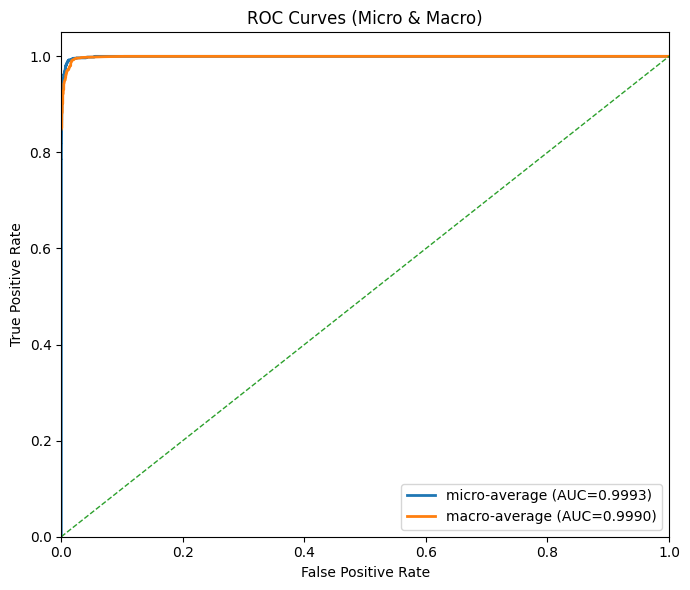

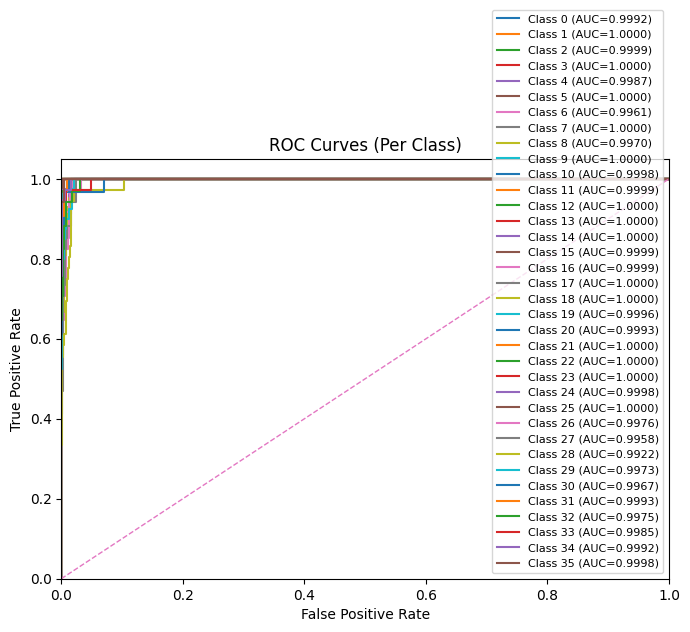


Classification Report (test):
              precision    recall  f1-score   support

           0     0.7907    0.9714    0.8718        35
           1     0.9677    1.0000    0.9836        30
           2     1.0000    0.9375    0.9677        32
           3     0.9744    1.0000    0.9870        38
           4     0.9615    0.9259    0.9434        27
           5     1.0000    0.9583    0.9787        24
           6     0.7429    0.7647    0.7536        34
           7     0.9750    1.0000    0.9873        39
           8     0.8250    0.7857    0.8049        42
           9     0.9643    1.0000    0.9818        27
          10     0.9730    0.9231    0.9474        39
          11     0.9412    0.9697    0.9552        33
          12     1.0000    1.0000    1.0000        41
          13     1.0000    0.9722    0.9859        36
          14     0.9706    1.0000    0.9851        33
          15     0.9706    0.9167    0.9429        36
          16     1.0000    0.9615    0.9804       

In [61]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits   = []
all_probs    = []
all_preds    = []
all_labels   = []


loader = test_loader 

t_test_start = time.time()
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(images)                       
            probs  = F.softmax(logits, dim=1)           

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs  = np.concatenate(all_probs, axis=0)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

# ====== (C) CONFUSION MATRIX ======
cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

# simple text view
def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

# Optional: plot CM (no seaborn)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score    = all_probs

if num_classes == 2:
   
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  
    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
   
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    # Plot micro & macro
    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()


print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))


In [62]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-5jo_z7f0
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-5jo_z7f0
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

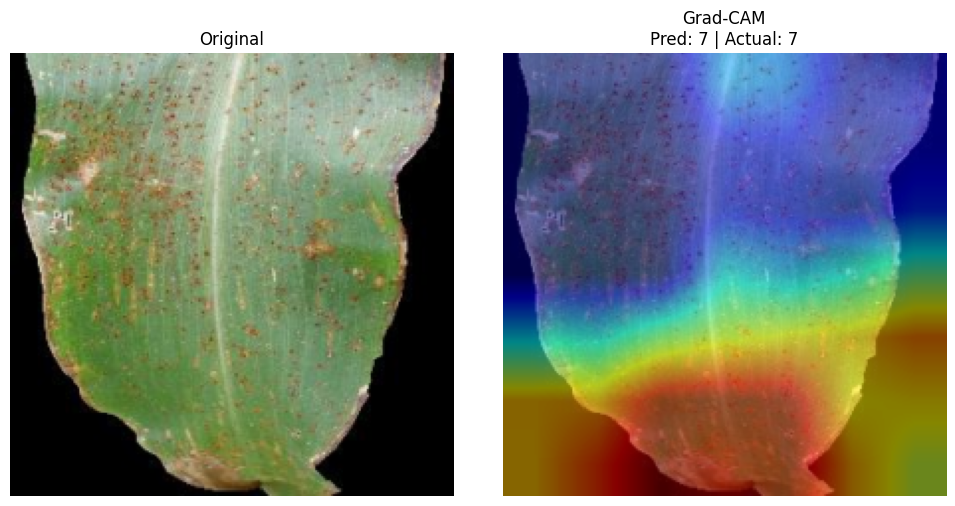

In [70]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.parameters():
    p.requires_grad_(True)


sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)


original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5
original_image_np = original_image_np.clip(0, 1)


target_layers = [model.inception5b]

cam = GradCAM(model=model, target_layers=target_layers)

outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()

targets = [ClassifierOutputTarget(predicted_class)]

# Compute Grad-CAM
grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]

result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)


class_names = getattr(test_dataset, "classes", None) or [str(i) for i in range(outputs.shape[1])]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()


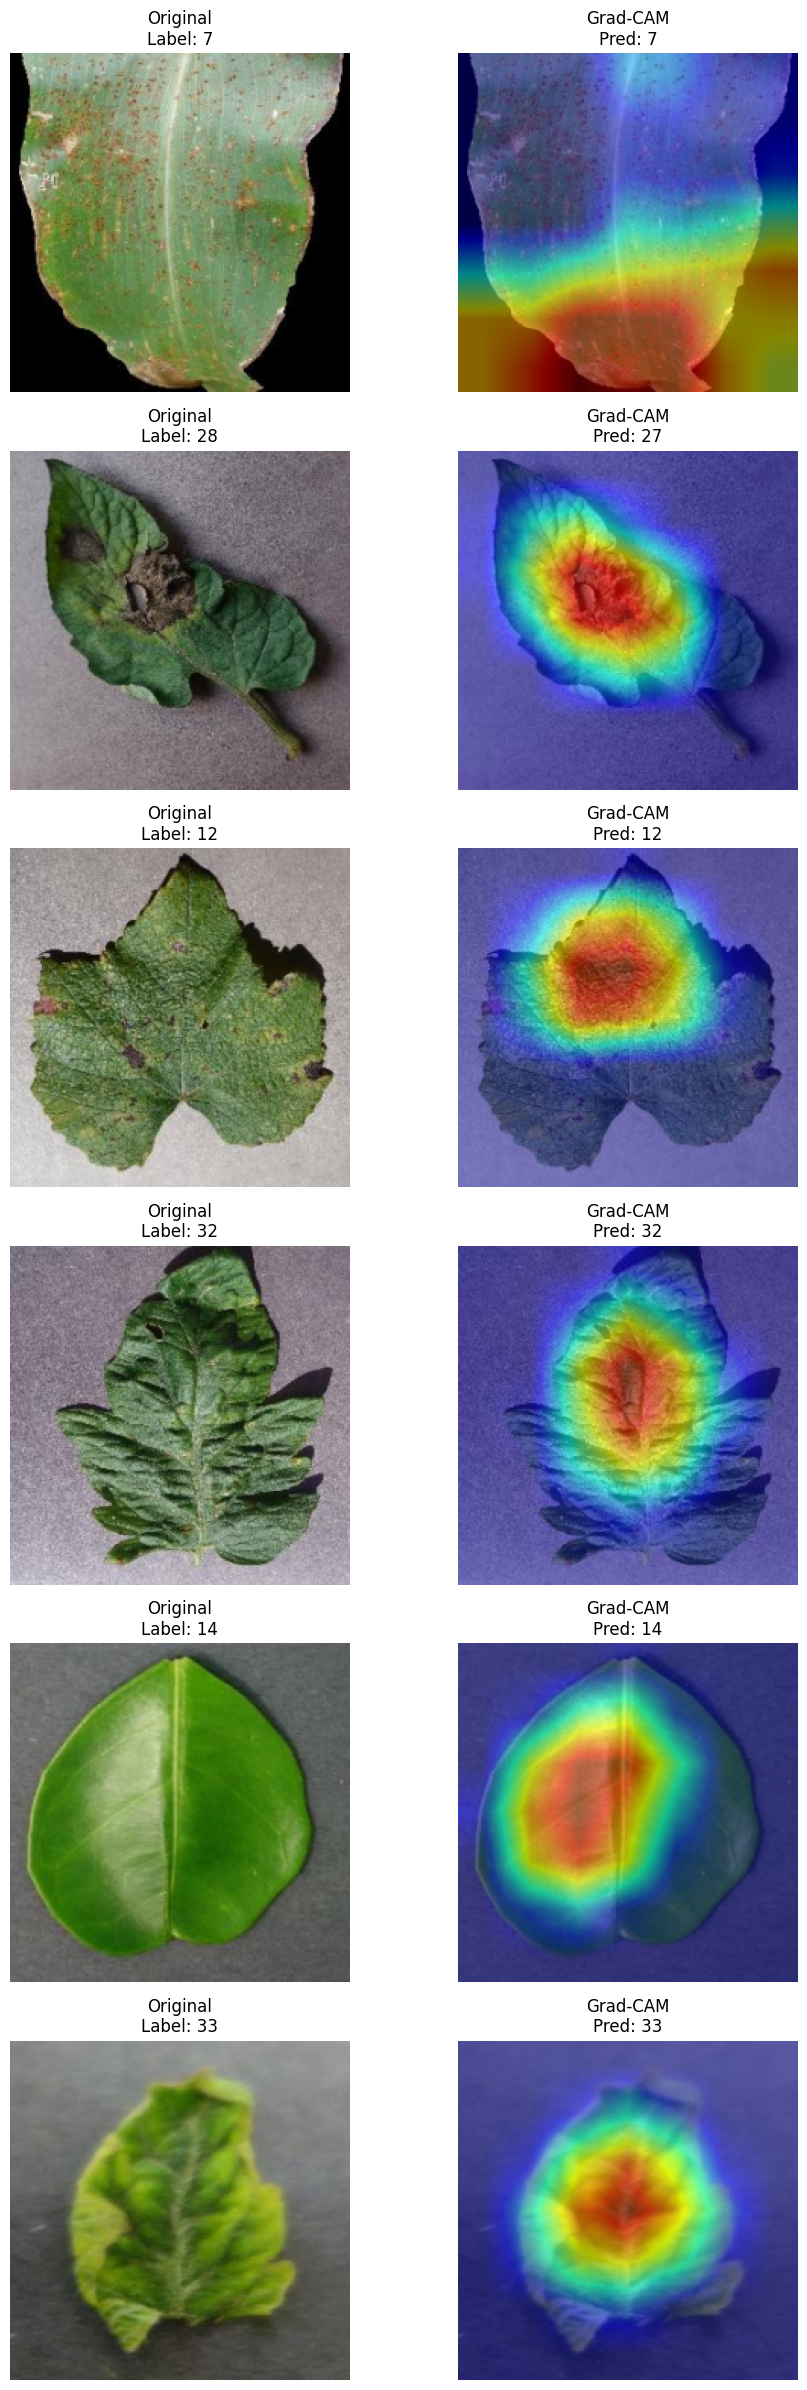

In [71]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

for p in model.parameters():
    p.requires_grad_(True)

target_layers = [model.inception5b]
cam = GradCAM(model=model, target_layers=target_layers)

class_names = getattr(test_dataset, "classes", None) or [str(i) for i in range(1000)]

num_images = 6

plt.figure(figsize=(10, num_images * 4))

for i in range(num_images):
    sample_image, label = test_dataset[i]
    sample_image = sample_image.unsqueeze(0).to(device)

    original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    original_image_np = (original_image_np * 0.5) + 0.5
    original_image_np = original_image_np.clip(0, 1)

    outputs = model(sample_image)
    predicted_class = outputs.argmax(dim=1).item()
    targets = [ClassifierOutputTarget(predicted_class)]

    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]
    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

    plt.subplot(num_images, 2, 2*i + 1)
    plt.title(f"Original\nLabel: {class_names[label]}")
    plt.imshow(original_image_np)
    plt.axis('off')

    plt.subplot(num_images, 2, 2*i + 2)
    plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]}")
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()
